In [1]:
%load_ext autoreload
%autoreload 2

import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
from scipy.stats import entropy
import time
import os
import copy
import sys
import gc
sys.path.append('./python_files')

from model_trainer import ModelTrainer
from utils import *
from data_loader import *
from nn_models import *

#!pip install Pillow==5.0.0

import numpy as np

data_dir = './data/imagenet/'
class_file = 'class_ids.txt'
TRAIN = 'uniform_training'
VAL = 'uniform_test'
TEST = 'uniform_val'

from PIL import Image
def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
Image.register_extension = register_extension
def register_extensions(id, extensions): 
    for extension in extensions: register_extension(id, extension)
Image.register_extensions = register_extensions

In [2]:
print("pytorch version: ",torch.__version__)
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    print("Using GPU: ",torch.cuda.get_device_name(0))

pytorch version:  1.0.0
Using GPU:  GeForce GTX 1080 Ti


In [3]:
# VGG-16 Takes 224x224 images as input, so we resize all of them
def load_imagenet(data_dir, batch_size=8, shuffle=True, num_workers=1, pin_memory=True):
    data_transforms = {
        TRAIN: transforms.Compose([
            # Data augmentation is a good practice for the train set
            # Here, we randomly crop the image to 224x224 and
            # randomly flip it horizontally.
            transforms.Resize(224),
            transforms.CenterCrop(224),
            #transforms.RandomResizedCrop(224),
            #transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]),
        TEST: transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
        ])
    }

    image_datasets = {
        x: datasets.ImageFolder(
            os.path.join(data_dir, x), 
            transform=data_transforms[x],
        )
        for x in [TRAIN, TEST]
    }

    dataloaders = {
        x: torch.utils.data.DataLoader(
            image_datasets[x], batch_size=batch_size,
            shuffle=shuffle, num_workers=num_workers,
            pin_memory=pin_memory
        )
        for x in [TRAIN, TEST]
    }
    
    class_names = image_datasets[TRAIN].classes

    dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, TEST]}

    for x in [TRAIN, TEST]:
        print("Loaded {} images under {}".format(dataset_sizes[x], x))
        
    return image_datasets, dataloaders, dataset_sizes, class_names

#print("Classes: ")

#print(image_datasets[TRAIN].classes)

In [4]:
image_datasets, dataloaders, dataset_sizes, class_names = load_imagenet(data_dir,
                           32, #batch_size
                           shuffle=True,
                           num_workers=1,
                           pin_memory=False)

Loaded 10000 images under uniform_training
Loaded 10000 images under uniform_val


In [5]:
use_gpu = torch.cuda.is_available()

def train_model(vgg, dataloaders, criterion, optimizer, scheduler, dataset_sizes, num_epochs=10, log_file=None):
    since = time.time()
    #best_model_wts = copy.deepcopy(vgg.state_dict())
    best_acc = 0.0
    
    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0
    
    train_batches = len(dataloaders[TRAIN])
    val_batches = len(dataloaders[TEST])
    
    hist = History()
    
    try:
        for epoch in range(num_epochs):
            since_batch = time.time()
            print("Epoch {}/{}".format(epoch, num_epochs))

            if log_file != None:
                log_file.write("Epoch {}/{}".format(epoch, num_epochs))
                log_file.flush()

            print('-' * 10)
            if log_file != None:
                log_file.write('\n')
                log_file.write('-' * 10)

            loss_train = 0
            loss_val = 0
            acc_train = 0
            acc_val = 0

            vgg.train(True)

            if log_file != None:
                log_file.write("\rTraining batch ...")
                log_file.flush()

            for i, data in enumerate(dataloaders[TRAIN]):

                if i % 1 == 0:
                    print("\rTraining batch {}/{}".format(i, train_batches), end='', flush=True)

                inputs, labels = data

                if use_gpu:
                    inputs, labels = inputs.cuda(), labels.cuda()

                optimizer.zero_grad()

                outputs = vgg(inputs)

                loss = criterion(outputs, labels)

                loss.backward()
                optimizer.step()

                with torch.no_grad():
                    loss_train += loss.data.item()

                    _, preds = torch.max(outputs.data, 1)
                    #print(preds, labels.data)
                    acc_train += torch.sum(preds == labels.data).item()

                del inputs, labels, outputs, preds, loss
                torch.cuda.empty_cache()

            elapsed_time = time.time() - since_batch
            print("\rEpoch completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
            print()

            if log_file != None:
                log_file.write("\rEpoch completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
                log_file.flush()

            # * 2 as we only used half of the dataset
            avg_loss = loss_train / float(dataset_sizes[TRAIN])
            avg_acc = acc_train / float(dataset_sizes[TRAIN])

            with torch.no_grad():
                vgg.train(False)
                vgg.eval()
                #criterion.eval()

                if log_file != None:
                    log_file.write("\rValidating ...")
                    log_file.flush()

                for i, data in enumerate(dataloaders[TEST]):
                    if i % 1 == 0:
                        print("\rValidation batch {}/{}".format(i, val_batches), end='', flush=True)

                    inputs, labels = data

                    if use_gpu:
                        inputs, labels = inputs.cuda(), labels.cuda()

                    optimizer.zero_grad()

                    outputs = vgg(inputs)

                    _, preds = torch.max(outputs.data, 1)
                    loss = criterion(outputs, labels)

                    loss_val += loss.data.item()
                    acc_val += torch.sum(preds == labels.data).item()

                    del inputs, labels, outputs, preds
                    torch.cuda.empty_cache()

            avg_loss_val = loss_val / dataset_sizes[TEST]
            avg_acc_val = acc_val / dataset_sizes[TEST]

            hist.add([
                avg_loss,
                avg_acc,
                avg_loss_val,
                avg_acc_val
            ])

            print()
            print("Epoch {} result: ".format(epoch))
            print("Avg loss (train): {:.4f}".format(avg_loss))
            print("Avg acc (train): {:.4f}".format(avg_acc))
            print("Avg loss (val): {:.4f}".format(avg_loss_val))
            print("Avg acc (val): {:.4f}".format(avg_acc_val))
            print('-' * 10)
            print()

            if log_file != None:
                log_file.write("\nEpoch {} result: ".format(epoch))
                log_file.write("\nAvg loss (train): {:.4f}".format(avg_loss))
                log_file.write("\nAvg acc (train): {:.4f}".format(avg_acc))
                log_file.write("\nAvg loss (val): {:.4f}\n".format(avg_loss_val))
                log_file.write("\nAvg acc (val): {:.4f}".format(avg_acc_val))
                log_file.write('-' * 10+"\n\n")
                log_file.flush()

            if avg_acc_val > best_acc:
                best_acc = avg_acc_val
                best_model_wts = copy.deepcopy(vgg.state_dict())
    except KeyboardInterrupt:
        print('\n\n'+'=' * 10)
        print('interrupted training ! (KeyboardInterrupt)')
        print('=' * 10)
        if log_file != None:
            log_file.write('\n\n'+'=' * 10)
            log_file.write('\ninterrupted training ! (KeyboardInterrupt)')
            log_file.write('\n'+'=' * 10)
            log_file.flush()
    except RuntimeError as error:
        del inputs, labels
        torch.cuda.empty_cache()
        raise error
        
    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))
    
    if log_file != None:
        log_file.write("\nTraining completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
        log_file.write("\nBest acc: {:.4f}".format(best_acc))
        log_file.flush()
    
    #vgg.load_state_dict(best_model_wts)
    return vgg, hist

In [6]:
vgg16 = models.vgg16()

if use_gpu:
    vgg16.cuda()

vgg16.load_state_dict(torch.load('./models/VGG16_imagenet_130_overfit.pt'))

### G

In [7]:
image_datasets, dataloaders, dataset_sizes, class_names= load_imagenet(data_dir,
                        32, #batch_size
                        shuffle=True,
                        num_workers=4,
                        pin_memory=False)

Loaded 10000 images under uniform_training
Loaded 10000 images under uniform_val


In [8]:
vgg16.eval()

with torch.no_grad():
    train_loader, test_loader = generate_dataloader_g(vgg16, 
                                                      dataloaders[TRAIN], 
                                                      dataloaders[TEST],
                                                      #[vgg16], ['end'])
                                                      [vgg16.features[7]], ['conv'], dim=16, axis=1, cpu=True)

    dataset_sizes_g = {TRAIN: len(train_loader), TEST: len(test_loader)}

1it [00:00,  1.99it/s]

picked 16 channels out of 128 :
 tensor([ 59,  15,  19,  77,  29,  41,  26,  42,   1, 113,   3,  31,  78,  99,
         40, 119])


313it [01:08,  5.27it/s]


In [9]:
def vgg_duh(layer_dim):
    dim = layer_dim[1]
    pool = 1
    finalVectorSize = layer_dim[2]//pool * layer_dim[3]//pool * dim
    model = nn.Sequential(
        nn.Conv2d(dim, dim, kernel_size=5, padding=2),
        nn.ReLU(),
        nn.BatchNorm2d(dim),
        
        View([-1]),
        nn.Linear(int(finalVectorSize), 1000),
        nn.ReLU(),
        nn.Linear(1000, 2),
    )
    return model

def dense_duh():
    model = nn.Sequential(
        View([1, -1]),
        nn.AvgPool1d(4, stride=4),
        View([-1]),
        
        nn.Linear(250, 64),
        nn.RReLU(),
        nn.Dropout(0.5),
        nn.BatchNorm1d(64),
        nn.Linear(64, 8),
        nn.RReLU(),
        nn.BatchNorm1d(8),
        nn.Linear(8, 2)
    )
    return model

In [18]:
def VGG16ResnetBlock(layer_dim):
    dim0 = layer_dim[1]
    dim = 16
    pad = (1, 1)
    pool = 1
    finalVectorSize = dim//pool * layer_dim[2]//pool * layer_dim[3]//pool
    print(finalVectorSize)
    model = nn.Sequential(
        nn.Conv2d(dim0, dim, kernel_size=3, padding = pad),
        nn.ReLU(),
        nn.BatchNorm2d(dim),
        
        nn.Conv2d(dim, dim, kernel_size=3, padding = pad),
        nn.ReLU(),
        nn.BatchNorm2d(dim),
        
        nn.Conv2d(dim, dim, kernel_size=3, padding = pad),
        nn.ReLU(),
        nn.BatchNorm2d(dim),
        
        nn.Conv2d(dim, dim, kernel_size=3, padding = pad),
        nn.ReLU(),
        nn.BatchNorm2d(dim),
        nn.MaxPool3d(pool),

        View([-1]),
        nn.Linear(finalVectorSize, 128),
        nn.ReLU(),
        nn.Linear(128, 128),
        nn.ReLU(),
        nn.Linear(128, 2)
    )
    return model


In [100]:
def VGG16ResnetG(layer_dim):
    input_dim = layer_dim[1]
    dim = 16
    pool = 2
    finalVectorSize = dim * (layer_dim[2]//pool//pool//pool) * (layer_dim[3]//pool//pool//pool)
    print(finalVectorSize)
    model = nn.Sequential(
        nn.Conv2d(input_dim, dim, kernel_size=3, padding = 1),
        nn.RReLU(),
        nn.BatchNorm2d(dim),
        nn.MaxPool2d(pool),
        
        nn.Conv2d(dim, dim, kernel_size=3, padding = 1),
        nn.RReLU(),
        nn.BatchNorm2d(dim),
        nn.MaxPool2d(pool),
        
        nn.Conv2d(dim, dim, kernel_size=3, padding = 1),
        nn.RReLU(),
        nn.BatchNorm2d(dim),
        nn.MaxPool2d(pool),
        
        #nn.AvgPool2d(layer_dim[2], stride=layer_dim[2]),
        View([-1]),
        nn.Linear(finalVectorSize, 8),
        nn.RReLU(),
        nn.Linear(8, 8),
        nn.RReLU(),
        nn.Linear(8, 2)
    )
    return model


In [101]:
layer_dim

torch.Size([64, 16, 112, 112])

In [102]:
model = VGG16ResnetG(layer_dim)
sum(x.numel() for x in model.parameters())

3136


32242

In [103]:
train_dataloader = DataLoader(train_loader, shuffle=True, pin_memory=False, batch_size=64)
test_dataloader = DataLoader(test_loader, shuffle=True, pin_memory=False, batch_size=64)

In [104]:
layer_dim = next(iter(train_dataloader))[0].shape
print("sample batch dimension :", layer_dim)

sample batch dimension : torch.Size([64, 16, 112, 112])


In [105]:
model = VGG16ResnetG(layer_dim)

if use_gpu:
    model.cuda() #.cuda() will move everything to the GPU side

resume_training = False

if resume_training:
    print("Loading model..")
    model.load_state_dict(torch.load('./models/G_vgg_duh.pt'))
    print("Loaded!")

criterion = nn.CrossEntropyLoss()

#optimizer_ft = optim.RMSprop(model.parameters(), lr=1e-3, momentum=0.2)
#optimizer_ft = optim.SGD(model.parameters(), lr=1e-2, momentum=0.6)
optimizer_ft = optim.Adamax(model.parameters(), lr=1e-3)
exp_lr_scheduler = None#lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

with open('G_training_output.txt', 'w') as f:
    model, hist = train_model(model, {TRAIN: train_dataloader, TEST: test_dataloader}, \
                  criterion, optimizer_ft, exp_lr_scheduler, dataset_sizes_g, num_epochs=30, log_file=f)
    
torch.save(model.state_dict(), './models/G_vgg_duh.pt')

3136
Epoch 0/30
----------
Epoch completed in 0m 34s

Validation batch 97/98
Epoch 0 result: 
Avg loss (train): 0.0108
Avg acc (train): 0.5142
Avg loss (val): 0.0108
Avg acc (val): 0.5266
----------

Epoch 1/30
----------
Epoch completed in 0m 42s

Validation batch 97/98
Epoch 1 result: 
Avg loss (train): 0.0107
Avg acc (train): 0.5481
Avg loss (val): 0.0108
Avg acc (val): 0.5392
----------

Epoch 2/30
----------
Epoch completed in 0m 44s

Validation batch 97/98
Epoch 2 result: 
Avg loss (train): 0.0106
Avg acc (train): 0.5663
Avg loss (val): 0.0108
Avg acc (val): 0.5440
----------

Epoch 3/30
----------
Epoch completed in 0m 43s

Validation batch 97/98
Epoch 3 result: 
Avg loss (train): 0.0103
Avg acc (train): 0.6053
Avg loss (val): 0.0110
Avg acc (val): 0.5354
----------

Epoch 4/30
----------
Epoch completed in 0m 44s

Validation batch 97/98
Epoch 4 result: 
Avg loss (train): 0.0099
Avg acc (train): 0.6353
Avg loss (val): 0.0110
Avg acc (val): 0.5501
----------

Epoch 5/30
---------

In [110]:
hist.get_best_val_acc()

0.55008

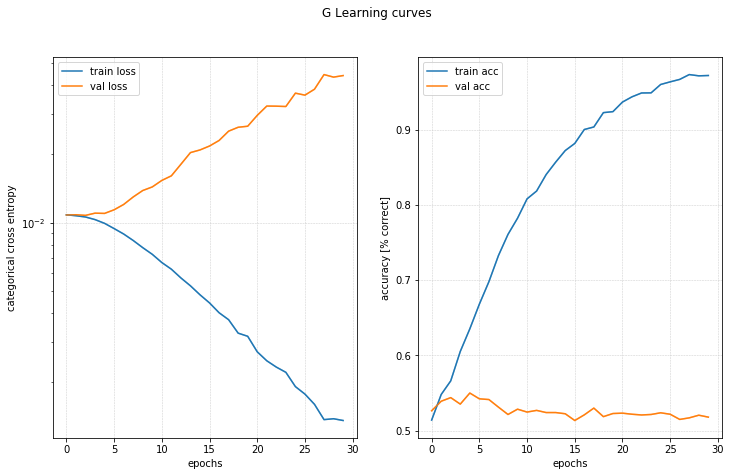

In [106]:
hist.plot("G Learning curves", 1)
plt.savefig("G_training_curves", dpi=300)

false negative percentage : 44.192
false positive percentage : 52.192


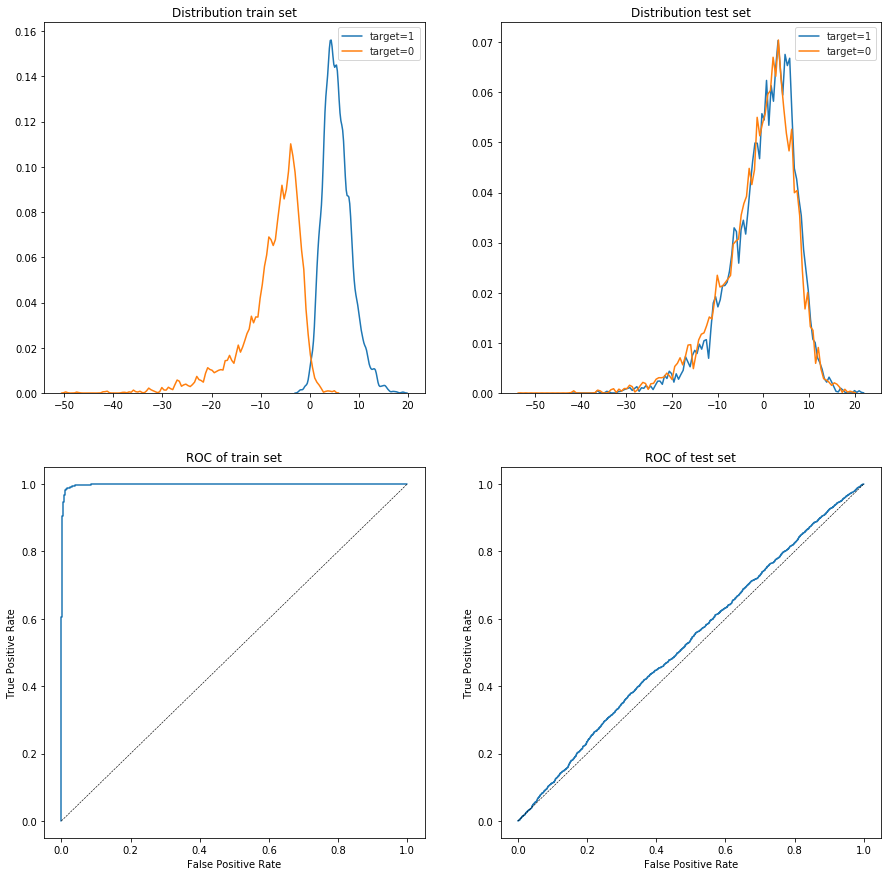


ROC score train : 0.9983631908301265
ROC score test : 0.5299173376


In [107]:
model.eval()
diagnostic_plots(model, train_dataloader, test_dataloader, bw=0.3, savefig=True)

In [37]:
#Free memory without restarting kernel
del train_loader, test_loader, dataloaders 
del train_dataloader, test_dataloader
del model, vgg16
del criterion, optimizer_ft, exp_lr_scheduler

gc.collect()
torch.cuda.empty_cache()